<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/2024_FIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.2 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
fia_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/FIA_HI/FIA_2023_2024/CONFIDENTIAL_select_HI_FIA_UniquePlots/select_HI_FIA_UniquePlots.csv')

In [6]:
cwd_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/FIA_HI/FIA_2023_2024/FIA_Data_2023_07_14/HI_DWM_COARSE_WOODY_DEBRIS.csv')

In [7]:
duff_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/FIA_HI/FIA_2023_2024/FIA_Data_2023_07_14/HI_DWM_DUFF_LITTER_FUEL.csv')

In [8]:
fwd_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/FIA_HI/FIA_2023_2024/FIA_Data_2023_07_14/HI_DWM_FINE_WOODY_DEBRIS.csv')

In [9]:
treebiom_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/FIA_HI/FIA_2023_2024/FIA_Data_2023_07_14/HI_TREE_REGIONAL_BIOMASS.csv')

In [10]:
fia_csv.head()

,OBJECTID,wkt_geom,fid,PLOT,INVYR,CN_loc,STATECD_loc,COUNTYCD_loc,SUBP_loc,INV_VST_NBR_loc,...,NOTES_OFFICE,GEOGRAPHIC_AREA,MC_Area,TOPO_POSITION_PNW,REMPER,NBP_CN,CONSERVATION_ZONE,PLOT_FIADB,LON_ACTUAL,LAT_ACTUAL
0,54,Point (-156.72577300000000378 21.1317179999999...,188,1653,2019,1219078217290480,15,9,2,1,...,0,0,0,4,4.5,48198341010497,,1653,-156.7257709,21.1360352
1,55,Point (-156.94999999999998863 21.1394039999999...,192,1655,2019,1219078348290480,15,9,2,1,...,0,0,0,4,4.5,48198343010497,R,1655,-156.9497262,21.1379136
2,56,Point (-157.08652499999999463 21.1066690000000...,197,1667,2019,1219078496290480,15,9,2,1,...,0,0,0,7,0,48198355010497,,1667,-157.0847822,21.1107204
3,57,Point (-156.75982500000000641 21.1015000000000...,202,1677,2019,1219084206290480,15,9,2,1,...,0,0,0,2,4.5,48198365010497,,1677,-156.7596882,21.104795
4,58,Point (-157.22623899999999253 21.0945649999999...,207,1681,2019,1219084342290480,15,9,2,1,...,0,0,0,3,0,48198369010497,,1681,-157.2278728,21.0944255


In [11]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [12]:
# Filter the DataFrame using .loc
fia_csv = fia_csv.loc[(fia_csv['LAT_ACTUAL'] != '') & (fia_csv['LON_ACTUAL'] != '')]

# Create geometry column
fia_csv['geometry'] = fia_csv.apply(lambda row: Point(float(row['LON_ACTUAL']), float(row['LAT_ACTUAL'])), axis=1)

# Convert to GeoDataFrame
fia_gpd = gpd.GeoDataFrame(fia_csv, geometry='geometry', crs="EPSG:4326")

In [13]:
column_names = list(fia_gpd.columns)
print(column_names)

['OBJECTID', 'wkt_geom', 'fid', 'PLOT', 'INVYR', 'CN_loc', 'STATECD_loc', 'COUNTYCD_loc', 'SUBP_loc', 'INV_VST_NBR_loc', 'PLT_CN_loc', 'CYCLE_loc', 'SUBCYCLE_loc', 'CONDID', 'C_TOT_3IN_MG_AC', 'CORE_BOTTOM_CD', 'CORE_LENGTH', 'CORE_SIZE', 'CREATED_BY', 'CREATED_DATE', 'CREATED_IN_INSTANCE', 'HOLE_DEPTH', 'MODIFIED_BY', 'MODIFIED_DATE', 'MODIFIED_IN_INSTANCE', 'N_TOT_3IN_MG_AC', 'NOTES', 'NOTES_OFFICE_loc', 'RESTRICTION_DEPTH_1', 'RESTRICTION_DEPTH_2', 'RESTRICTION_DEPTH_3', 'RESTRICTION_DEPTH_4', 'RESTRICTION_DEPTH_CD_1', 'RESTRICTION_DEPTH_CD_2', 'RESTRICTION_DEPTH_CD_3', 'RESTRICTION_DEPTH_CD_4', 'SOILS_SAMPLE_METHOD_CD', 'SOILS_SAMPLE_STATUS_CD', 'UNITCD', 'USED_IN_ESTIMATION_CD', 'VSTNBR_loc', 'CN_lyr', 'STATECD_lyr', 'COUNTYCD_lyr', 'SUBP_lyr', 'INV_VST_NBR_lyr', 'PLT_CN_lyr', 'CYCLE_lyr', 'SUBCYCLE_lyr', 'BRAY1_P', 'BULK_DENSITY', 'BULK_DENSITY_FINES', 'C_INORG_PCT', 'C_MG_AC', 'C_MIN3_MG_AC', 'C_ORG_PCT', 'C_TOTAL_PCT', 'COARSE_FRACTION_PCT', 'FIELD_SAMPLE_LBL', 'LAB_ID', 'LAYER

In [14]:
print("There are", fia_csv.shape[0], 'rows and', fia_csv.shape[1], "columns.")

There are 311 rows and 146 columns.


In [15]:
fia_csv['HOLE_DEPTH'].apply(type).value_counts()

,count
HOLE_DEPTH,
<class 'str'>,311


In [16]:
fia_csv['C_MG_AC'].nunique()

215

In [17]:
bins = pd.cut(fia_csv['C_MG_AC'].astype(float), bins=10)
fia_csv['C_MG_AC_Binned'] = bins.astype(str)

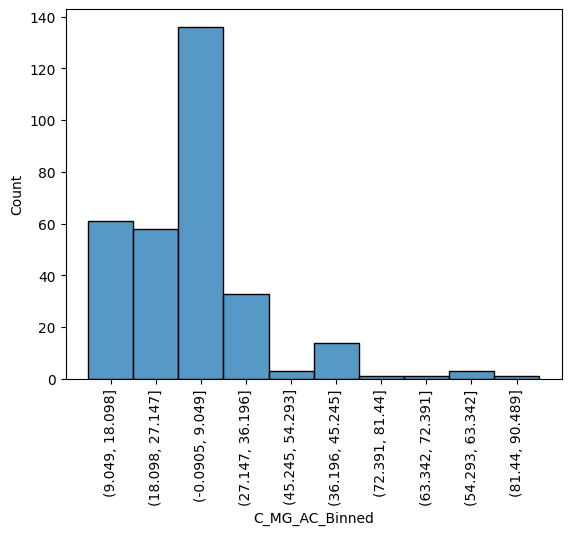

In [18]:
sns.histplot(fia_csv['C_MG_AC_Binned'], bins=10, kde=False)
plt.xticks(rotation=90)
plt.show()

In [19]:
# numeric_df = fia_csv.select_dtypes(include=[float, int])
# numeric_df

fia_csv['C_MG_AC'] = fia_csv['C_MG_AC'].astype(float)

In [20]:
# Conversion factor from acres to hectares
conversion_factor = 2.47105

# Convert Mg C/acre to Mg C/ha and add as a new column
fia_csv['C_MG_HA'] = fia_csv['C_MG_AC'] * conversion_factor


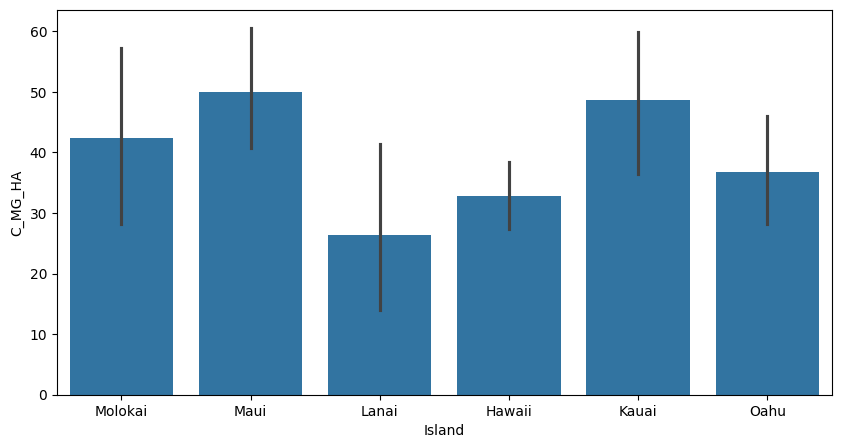

In [21]:
# Island
plt.figure(figsize=(10, 5))
sns.barplot(data=fia_csv, x='Island', y='C_MG_HA')
plt.show()

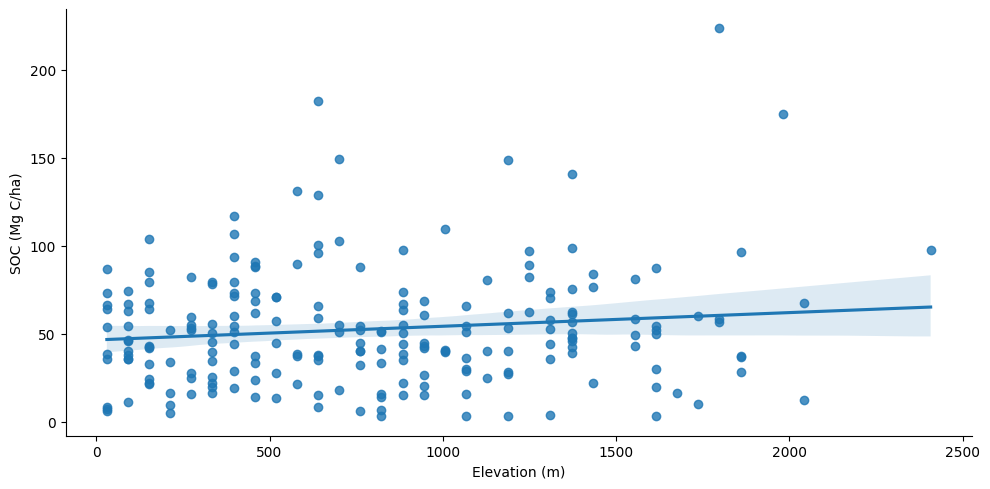

In [22]:
fia_csv['ELEV'] = pd.to_numeric(fia_csv['ELEV'], errors='coerce')
fia_csv['C_MG_HA'] = pd.to_numeric(fia_csv['C_MG_HA'], errors='coerce')
fia_csv['PRECIPITATION'] = pd.to_numeric(fia_csv['PRECIPITATION'], errors='coerce')

# Drop any rows with NaN values or zeros
fia_csv = fia_csv.dropna(subset=['ELEV', 'C_MG_HA','PRECIPITATION'])
fia_csv = fia_csv[(fia_csv['ELEV'] != 0) & (fia_csv['C_MG_HA'] != 0) & (fia_csv['PRECIPITATION'] != 0)]

fia_csv['ELEV_M'] = fia_csv['ELEV'] * 0.3048

# Create the scatter plot with lmplot which includes a trendline
sns.lmplot(data=fia_csv, x='ELEV_M', y='C_MG_HA', height=5, aspect=2)

# Add labels and title
plt.xlabel('Elevation (m)')
plt.ylabel('SOC (Mg C/ha)')

# Show the plot
plt.show()

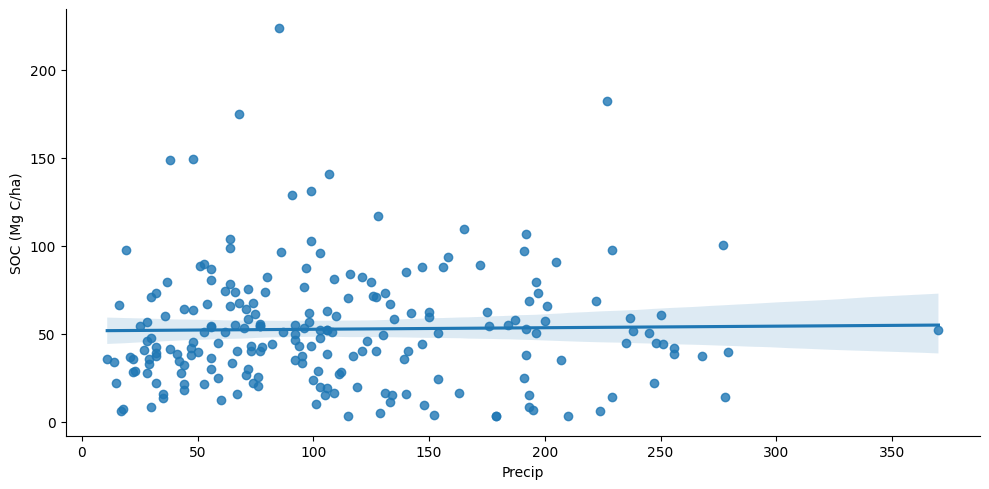

In [23]:
sns.lmplot(data=fia_csv, x='PRECIPITATION', y='C_MG_HA', height=5, aspect=2)

# Add labels and title
plt.xlabel('Precip')
plt.ylabel('SOC (Mg C/ha)')

# Show the plot
plt.show()


In [24]:
fia_csv[['PRECIPITATION','C_MG_HA']].corr()
fia_csv[['ELEV','C_MG_HA']].corr()

,ELEV,C_MG_HA
ELEV,1.000000,0.124189
C_MG_HA,0.124189,1.000000


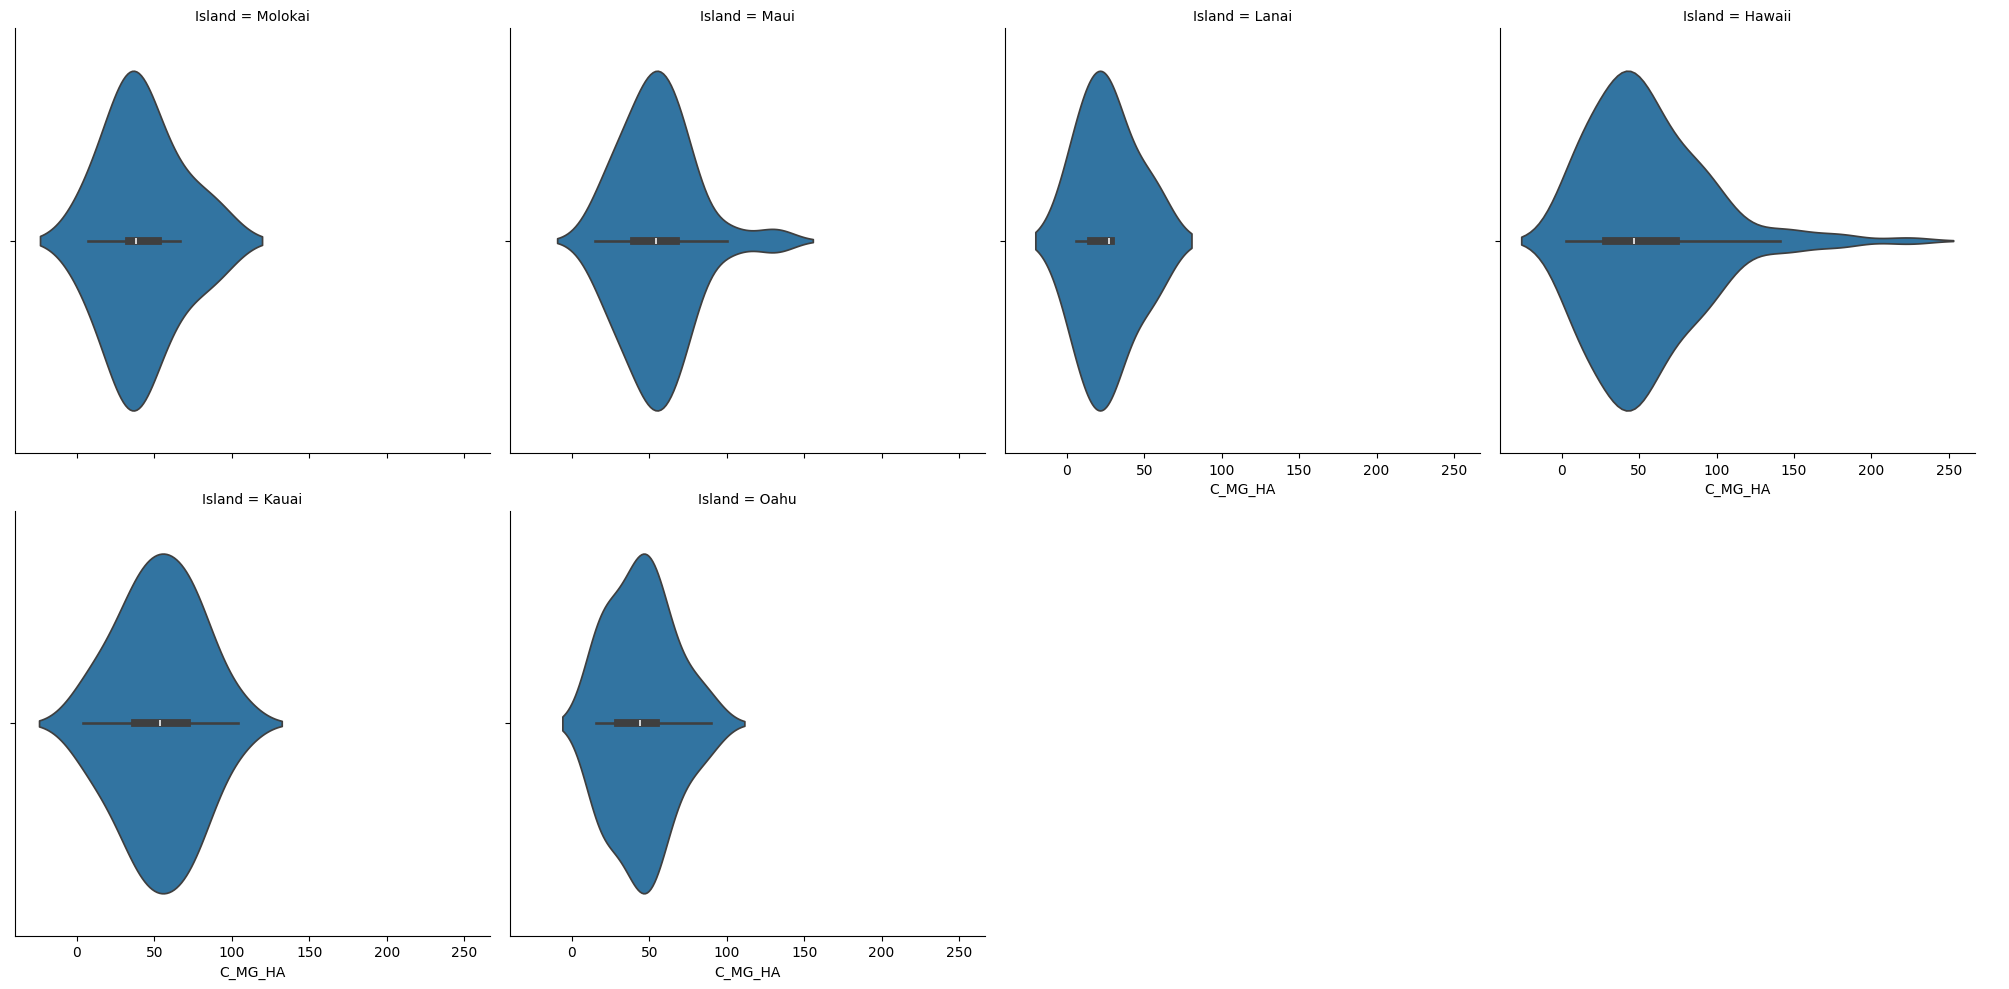

In [25]:
sns.catplot(x='C_MG_HA',
            col='Island',
            data=fia_csv,
            col_wrap=4,
            kind="violin")
plt.show()

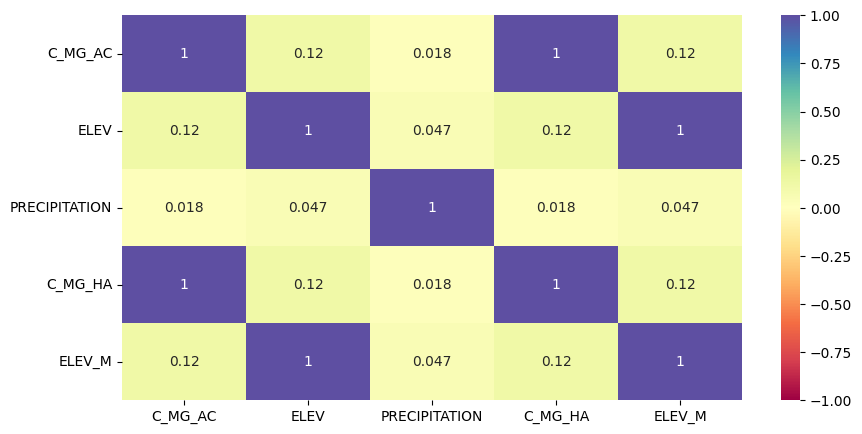

In [26]:
numeric_df = fia_csv.select_dtypes(include=[float, int])

plt.figure(figsize=(10,5))
sns.heatmap(numeric_df.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)
plt.show()

In [ ]:
# ['OBJECTID', 'wkt_geom', 'fid', 'PLOT', 'INVYR', 'CN_loc', 'STATECD_loc', 'COUNTYCD_loc', 'SUBP_loc', 'INV_VST_NBR_loc', 'PLT_CN_loc', 'CYCLE_loc',
#'SUBCYCLE_loc', 'CONDID', 'C_TOT_3IN_MG_AC', 'CORE_BOTTOM_CD', 'CORE_LENGTH', 'CORE_SIZE', 'CREATED_BY', 'CREATED_DATE', 'CREATED_IN_INSTANCE',
#'HOLE_DEPTH', 'MODIFIED_BY', 'MODIFIED_DATE', 'MODIFIED_IN_INSTANCE', 'N_TOT_3IN_MG_AC', 'NOTES', 'NOTES_OFFICE_loc', 'RESTRICTION_DEPTH_1',
#'RESTRICTION_DEPTH_2', 'RESTRICTION_DEPTH_3', 'RESTRICTION_DEPTH_4', 'RESTRICTION_DEPTH_CD_1', 'RESTRICTION_DEPTH_CD_2', 'RESTRICTION_DEPTH_CD_3',
# 'RESTRICTION_DEPTH_CD_4', 'SOILS_SAMPLE_METHOD_CD', 'SOILS_SAMPLE_STATUS_CD', 'UNITCD', 'USED_IN_ESTIMATION_CD', 'VSTNBR_loc', 'CN_lyr', 'STATECD_lyr',
# 'COUNTYCD_lyr', 'SUBP_lyr', 'INV_VST_NBR_lyr', 'PLT_CN_lyr', 'CYCLE_lyr', 'SUBCYCLE_lyr', 'BRAY1_P', 'BULK_DENSITY', 'BULK_DENSITY_FINES', 'C_INORG_PCT',
# 'C_MG_AC', 'C_MIN3_MG_AC', 'C_ORG_PCT', 'C_TOTAL_PCT', 'COARSE_FRACTION_PCT', 'FIELD_SAMPLE_LBL', 'LAB_ID', 'LAYER_COLLECTED_CD', 'LAYER_THICKNESS',
#'LAYER_TYPE', 'N_MG_AC', 'N_MIN3_MG_AC', 'N_TOTAL_PCT', 'NOTES_OFFICE_lyr', 'OLSEN_P', 'PH_CACL2', 'PH_H2O', 'SAMPLE_DIA', 'SAMPLER_TYPE', 'SOIL_SAMP_PER_AC',
# 'SSSL_CN', 'TEXTURE_CD', 'VSTNBR_lyr', 'WATER_CONTENT_PCT_FIELD_MOIST', 'WATER_CONTENT_PCT_RESIDUAL', 'WATER_CONTENT_PCT_TOTAL', 'WT_AIR_DRY', 'WT_FIELD_MOIST',
# 'WT_OVEN_DRY', 'WT_ROCK', 'CN', 'SRV_CN', 'CTY_CN', 'MEASYEAR', 'STATECD', 'COUNTYCD', 'Island_Group', 'County_Name', 'UNITCD_plot', 'PLOT_STATUS_CD',
#'PLOT_NONSAMPLE_REASN_CD', 'CONGCD', 'DECLINATION', 'DESIGNCD', 'ECOSUBCD', 'ELEV', 'INTENSITY', 'INVASIVE_SAMPLING_STATUS_CD', 'INVASIVE_SPECIMEN_RULE_CD',
#'KINDCD', 'MANUAL', 'MEASMON', 'MEASDAY', 'MICROPLOT_LOC', 'NF_PLOT_STATUS_CD', 'NF_PLOT_NONSAMPLE_REASN_CD', 'NF_SAMPLING_STATUS_CD', 'P2VEG_SAMPLING_STATUS_CD',
#'P2VEG_SAMPLING_LEVEL_DETAIL_CD', 'PRECIPITATION', 'PUBUSECD', 'QA_STATUS', 'RDCD', 'RDDISTCD', 'RDUSECD', 'REUSECD1', 'REUSECD2', 'REUSECD3', 'SAMP_METHOD_CD',
#'SUBP_EXAMINE_CD', 'WATERCD', 'CYCLE', 'SUBCYCLE', 'P2PANEL', 'SUBPANEL', 'PREV_PLT_CN', 'Island', 'RGN_FLG', 'RGN_TYP', 'OWNER_NAME', 'OWNER_SUBNAME', 'NOTES_plot',
#'NOTES_OFFICE', 'GEOGRAPHIC_AREA', 'MC_Area', 'TOPO_POSITION_PNW', 'REMPER', 'NBP_CN', 'CONSERVATION_ZONE', 'PLOT_FIADB', 'LON_ACTUAL', 'LAT_ACTUAL', 'geometry']



In [31]:
# Basic summary statistics
print(fia_csv['COARSE_FRACTION_PCT'].describe())

# Additional information such as unique values and counts of non-null values
print(fia_csv['COARSE_FRACTION_PCT'].value_counts())
print(fia_csv['COARSE_FRACTION_PCT'].isnull().sum())


count     214
unique     73
top         0
freq      142
Name: COARSE_FRACTION_PCT, dtype: object
COARSE_FRACTION_PCT
0        142
3.604      1
1.961      1
8.908      1
8.031      1
        ... 
0.168      1
0.131      1
0.11       1
9.247      1
0.705      1
Name: count, Length: 73, dtype: int64
0


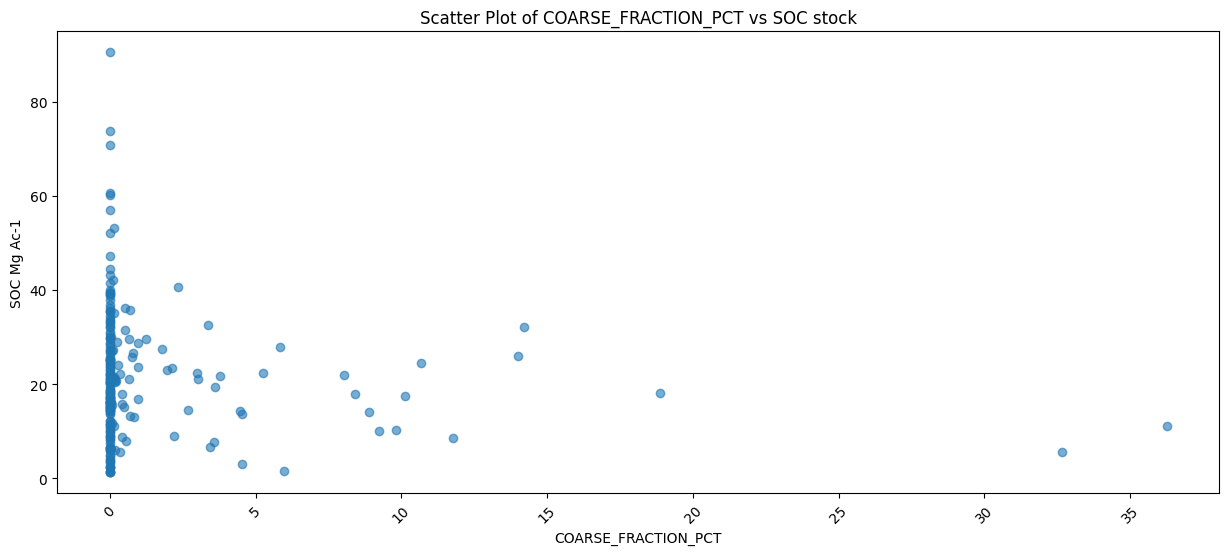

In [39]:
fia_csv['COARSE_FRACTION_PCT'] = pd.to_numeric(fia_csv['COARSE_FRACTION_PCT'], errors='coerce')

plt.figure(figsize=(15, 6))

plt.scatter(fia_csv['COARSE_FRACTION_PCT'], fia_csv['C_MG_AC'], alpha=0.6)

plt.title("Scatter Plot of COARSE_FRACTION_PCT vs SOC stock")

plt.xlabel("COARSE_FRACTION_PCT")

plt.ylabel("SOC Mg Ac-1")

# plt.xticks(ticks=plt.xticks()[0][::2], rotation=45)

plt.xticks(rotation=45)

plt.show()

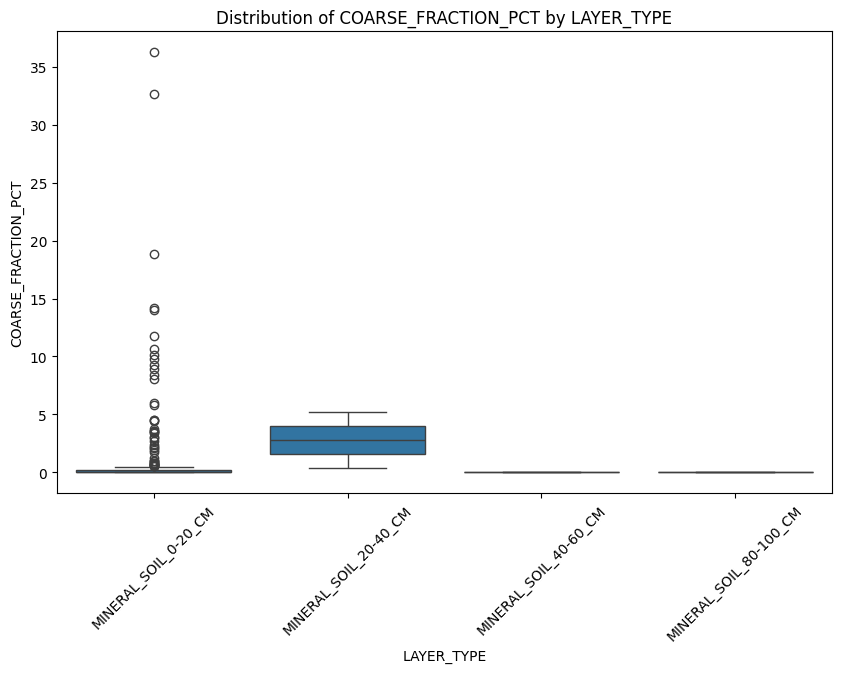

In [40]:
fia_csv['COARSE_FRACTION_PCT'] = pd.to_numeric(fia_csv['COARSE_FRACTION_PCT'], errors='coerce')

# Plot COARSE_FRACTION_PCT by LAYER_TYPE using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=fia_csv, x='LAYER_TYPE', y='COARSE_FRACTION_PCT')
plt.title("Distribution of COARSE_FRACTION_PCT by LAYER_TYPE")
plt.xlabel("LAYER_TYPE")
plt.ylabel("COARSE_FRACTION_PCT")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()